# Distribution Analysis to Decide Stock Buy and Sell Price

#### ©2020 Jingkai Lin

## import modules

In [7]:
import FundamentalAnalysis
import yfinance as yf
import pandas as pd
import FundamentalAnalysis as fa
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import sklearn.decomposition as dcps
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode,  plot
from plotly.graph_objs import *
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from fitter import Fitter
from scipy.optimize import curve_fit
import scipy
from scipy import optimize
from scipy.stats import gamma, lognorm, halflogistic, foldcauchy

Using TensorFlow backend.


## import data

In [8]:
###import data
ticker = "KMI"
api_key = "d0f70c830f0f55737305f5507973bbf2"

# Collect general company information
profile = fa.profile(ticker, api_key)


# Show recommendations of Analysts
ratings = fa.rating(ticker, api_key)

#hourly data for the most recent two years
df3 = fa.stock_data(ticker, period="2y", interval="1h")

#daily data from the begining of the stock
df4 = fa.stock_data_detailed(ticker, api_key, begin="2000-01-01", end="2018-06-10")

#append two dataset
df =pd.DataFrame(df3['close'].append(df4['close']))
df.close = df.close.astype(float)
df = df.round({'close':1})


Data for 'adjclose' could not be included.


## distribution analysis

### try fitting the data distribution with  a quadratic polynomial background with a Gaussian peak

#### $$A(f) = a + bf + cf^2 + P e^{-\frac{1}{2}[(f-f_p)/f_w]^2}$$

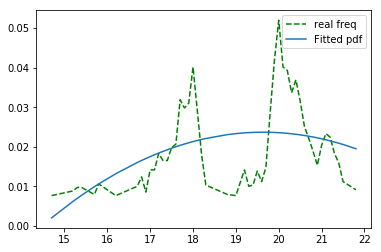

In [33]:
df2 = df['close'].value_counts().sort_index().reset_index()
df2.columns = ['price','freq']
df2 = df2.loc[df2['freq']>25]
def GaussPolyBase(f, a, b, c, P, fp, fw):
    return a + b*f + c*f*f + P*np.exp(-0.5*((f-fp)/fw)**2)

nlfit, nlpcov = optimize.curve_fit(GaussPolyBase,df2['price'],df2['freq']/sum(df2['freq']),method = 'trf')


plt.plot(df2['price'],df2['freq']/sum(df2['freq']),"g--",label = 'real freq')
plt.plot(df2['price'], GaussPolyBase(df2['price'], nlfit[0],
                                     nlfit[1],
                                     nlfit[2],
                                     nlfit[3],
                                     nlfit[4],
                                     nlfit[5]),label='Fitted pdf')

plt.legend(loc='best')

plt.show()

In [34]:
# have a look at the parameters estimated
nlfit

array([-3.19064283e-01,  3.49152278e-02, -8.89194549e-04,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00])

#### solve differential equatoin to get percentile
#### this is not finally resolved since the time consuming for the differential equation is too long

In [39]:
from scipy.integrate import solve_ivp
def func2(f, y):nlfit[0]+ nlfit[1]*f + nlfit[2]*f*f + nlfit[3]*np.exp(-0.5*((f-nlfit[4])/nlfit[5])**2)

In [ ]:
sol = solve_ivp(func2, [13, 20], [0.1,0.3])

### try lognormal distribution

C:\Users\jingk\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



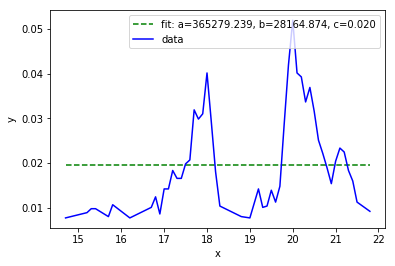

In [12]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
 
popt, pcov = curve_fit(func,df2['price'],df2['freq']/sum(df2['freq']))


plt.plot(df2['price'], func(df2['price'], *popt), 'g--',
             label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(df2['price'],df2['freq']/sum(df2['freq']), 'b-', label='data')
                          
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

###### not good at all for normal distribution

### I surrendar and will use basic statistics

Data for 'adjclose' could not be included.


2.1993025088156877

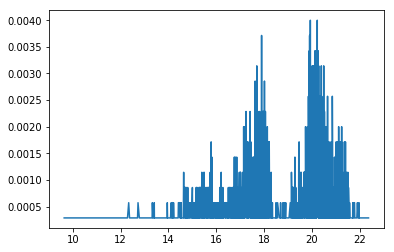

In [61]:
df3 = fa.stock_data(ticker, period="2y", interval="1h")

df5 = df3['close'].value_counts().sort_index().reset_index()
df5.columns = ['price','freq']
plt.plot(df5['price'],df5['freq']/sum(df5['freq']),label = 'real freq')


df3.close = df3.close.astype(float)

a = list(range(1,100))
percentile = [i/100 for i in a]
percentile_result = df3.close.quantile(percentile)
mean = df3.close.mean()
df3.close.median()
df3.close.std()


#### buy price will be the 15% percentile calcualted by the mean of [real percentile, percentile from normal distribution]

In [62]:
(percentile_result.iloc[14]+(mean-1.04*df3.close.std()))/2

16.278751235956264

#### sell price will be the mean of median and mean

In [63]:
(mean + percentile_result.iloc[49])/2

19.02738903645107